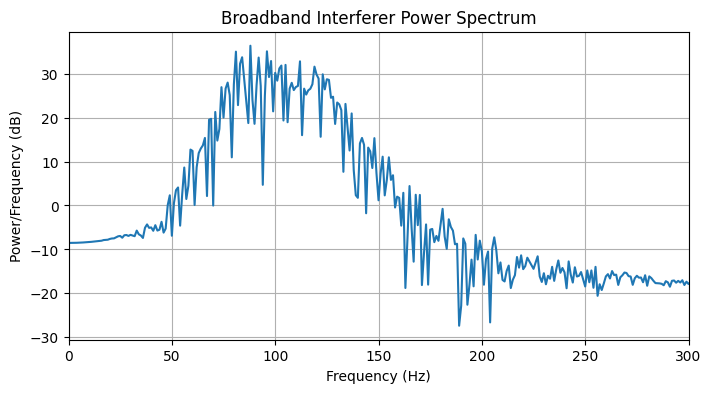

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

# Sampling parameters
fs = 1000  # Sampling frequency in Hz (>= 2*500 for Nyquist)
T = 1.0    # Duration in seconds
N = int(fs * T)
t = np.arange(N) / fs

# Generate white Gaussian noise
white_noise = np.random.randn(N)

# Butterworth bandpass filter for interferer around 100 Hz with 100 Hz bandwidth
center_freq = 100.0
bandwidth = 50.0
lowcut = center_freq - bandwidth/2  # 50 Hz
highcut = center_freq + bandwidth/2 # 150 Hz
order = 4

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = lfilter(b, a, data)
    return filtered

# Create broadband interferer by filtering white noise
interferer = bandpass_filter(white_noise, lowcut, highcut, fs, order)

# Normalize or scale as appropriate
interferer /= np.max(np.abs(interferer))

# Plot power spectral density to verify
freqs = np.fft.rfftfreq(N, 1/fs)
spectrum = np.abs(np.fft.rfft(interferer))**2

plt.figure(figsize=(8,4))
plt.plot(freqs, 10*np.log10(spectrum), label='Interferer PSD')
plt.xlim(0, 300)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB)')
plt.title('Broadband Interferer Power Spectrum')
plt.grid(True)
plt.show()

Scaled noise power: 0.10000
Scaled int noise power: 1.00000


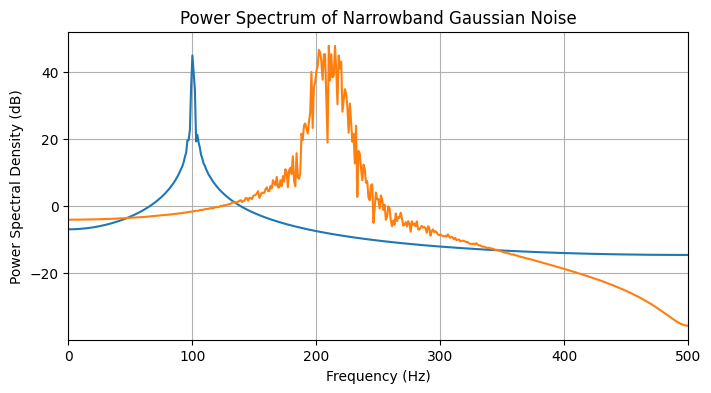

In [17]:
import numpy as np
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

# Parameters
fs = 1000          # Sampling frequency (Hz)
T = 1.0            # Signal duration (seconds)
N = int(fs * T)
t = np.arange(N)/fs

# Desired narrowband specs
lowcut = 99.0      # Lower cutoff frequency (Hz)
highcut = 102.0    # Upper cutoff frequency (Hz)

lowcut_int = 200
highcut_int = 220
desired_power = .1  # Desired power level (RMS^2)
desired_power_int = 1

# Generate white Gaussian noise
white_noise = np.random.randn(N)
white_noise_int= np.random.randn(N)

# Bandpass filter design
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b,a = butter_bandpass(lowcut, highcut, fs, order)
    return lfilter(b,a,data)

# Apply bandpass filter
filtered_noise = bandpass_filter(white_noise, lowcut, highcut, fs)
filtered_noise_int = bandpass_filter(white_noise_int, lowcut_int, highcut_int, fs)

# Calculate current power
current_power = np.mean(filtered_noise**2)
current_power_int = np.mean(filtered_noise_int ** 2)

# Scale to desired power
scaled_noise = filtered_noise * np.sqrt(desired_power / current_power)
scaled_noise_int = filtered_noise_int * np.sqrt(desired_power_int / current_power_int)

# Verify power
print(f"Scaled noise power: {np.mean(scaled_noise**2):.5f}")
print(f"Scaled int noise power: {np.mean(scaled_noise_int ** 2):.5f}")

# Plot power spectral density
freqs = np.fft.rfftfreq(N, 1/fs)
spectrum = np.abs(np.fft.rfft(scaled_noise))**2
spectrum_int = np.abs(np.fft.rfft(scaled_noise_int))**2

plt.figure(figsize=(8,4))
plt.plot(freqs, 10 * np.log10(spectrum))
plt.plot(freqs, 10 * np.log10(spectrum_int))
plt.title("Power Spectrum of Narrowband Gaussian Noise")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB)")
plt.xlim(0, 500)
plt.grid(True)
plt.show()

(8,)


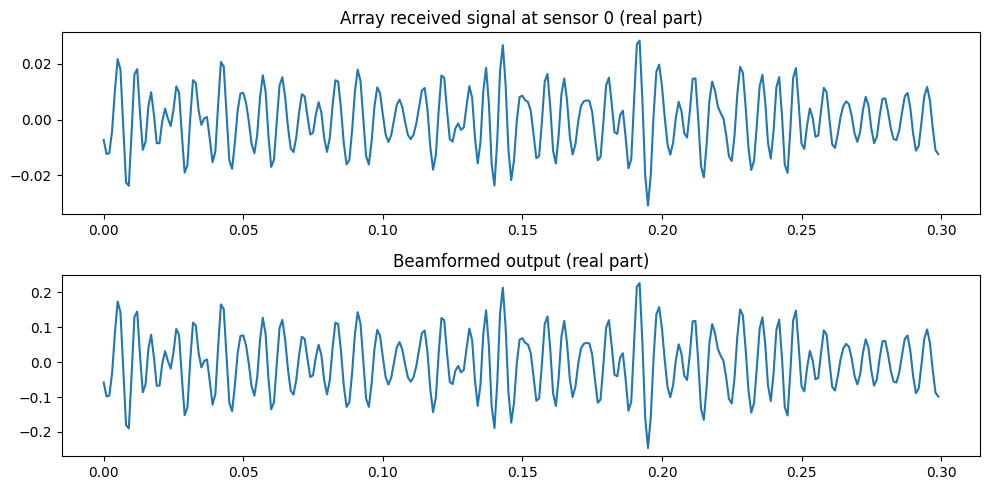

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
fs = 1000           # Sampling frequency (Hz)
T = 1.0              # Duration (s)
N = int(fs * T)      # Samples
t = np.arange(N) / fs

num_sensors = 8
wavelength = 1.0     # Normalized (so c = 1.0)
d = 0.5 * wavelength # Sensor spacing (half λ)
c = 1.0              # Wave propagation speed (normalized)
doa_deg = 30         # Direction of arrival of the source

# --- Generate a complex broadband signal ---
# For realism: band-limited noise
low_freq, high_freq = 100, 200  # Hz
freqs = np.fft.fftfreq(N, d=1/fs)

X = np.zeros(N, dtype=complex)  # Frequency domain template
band_mask = (np.abs(freqs) >= low_freq) & (np.abs(freqs) <= high_freq)
X[band_mask] = (np.random.randn(np.sum(band_mask)) +
                1j*np.random.randn(np.sum(band_mask))) / np.sqrt(2)
source_signal = np.fft.ifft(X)

# --- Compute sensor delays for this DoA ---
angle_rad = np.deg2rad(doa_deg)
sensor_positions = np.arange(num_sensors) * d
delays = sensor_positions * np.cos(angle_rad) / c  # Seconds

# --- Simulate received signals: apply delays in frequency domain ---
freqs = np.fft.fftfreq(N, d=1/fs)  # Cycles/sec
received = np.zeros((num_sensors, N), dtype=complex)

for m, tau in enumerate(delays):
    # FFT of source
    S_f = np.fft.fft(source_signal)
    # Phase shift for each frequency bin: exp(-j 2π f tau)
    phase_shift = np.exp(-1j * 2 * np.pi * freqs * tau)
    # Apply phase slope to broadband signal
    X_shifted = S_f * phase_shift
    # IFFT back to time domain
    received[m, :] = np.fft.ifft(X_shifted)

# --- Beamform: steer to the known DoA ---
# Here beamform by aligning all sensor signals to this DoA and summing
bf_output_freqs = np.zeros(N, dtype=complex)
S_freqs = np.fft.fft(received, axis=1)  # FFT per sensor (axis=1 is time)
for m, tau in enumerate(delays):
    steering_phase = np.exp(1j * 2 * np.pi * freqs * tau)  # opposite of delay
    bf_output_freqs += S_freqs[m, :] * steering_phase

beamformed_time = np.fft.ifft(bf_output_freqs)

# --- Plot ---
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.title("Array received signal at sensor 0 (real part)")
plt.plot(t[:300], np.real(received[0,:300]))

plt.subplot(2,1,2)
plt.title("Beamformed output (real part)")
plt.plot(t[:300], np.real(beamformed_time[:300]))
plt.tight_layout()
plt.show()

In [199]:
from spatial_filtering import arrays, constants


def simulate(
    array: arrays.Array,
    source_f_low: float,
    source_f_high: float,
    interferer_f_low: list[float],
    interferer_f_high: list[float],
    source_theta_deg: float,
    interferer_theta_deg: list[float],
    source_power: float,
    interferer_power: list[float],
    time_points: np.ndarray,
    sigma: float = 0.5,
    sampling_frequency: float = 1_000,
    center_freq: float = 1e9,
):
    if not isinstance(interferer_theta_deg, list) and not isinstance(
        interferer_theta_deg, np.ndarray
    ):
        interferer_theta_deg = [interferer_theta_deg]

    freqs = np.fft.fftfreq(len(time_points), d=1 / sampling_frequency)
    freqs_nozero = np.copy(freqs)
    freqs_nozero[freqs_nozero == 0] = 1e-12
    output = np.zeros((1, time_points.shape[0]), dtype=np.complex128)

    for power, theta, low_freq, high_freq in zip(
        interferer_power + [source_power],
        interferer_theta_deg + [source_theta_deg],
        interferer_f_low + [source_f_low],
        interferer_f_high + [source_f_high],
    ):
        X = np.zeros(len(time_points), dtype=complex)
        band_mask = (center_freq + freqs >= low_freq) & (
            center_freq + freqs <= high_freq
        )
        X[band_mask] = (
            np.random.randn(np.sum(band_mask)) + 1j * np.random.randn(np.sum(band_mask))
        ) / np.sqrt(2)
        print(X.shape)
        theta_rad = np.deg2rad(theta)
        steer_vec = array.steering_vector(
            theta_rad, constants.c / (center_freq + freqs)
        )  # num_antennas x num_freqs
        print(steer_vec.shape)
        X = steer_vec * X
        print(X.shape)
        source_signal = np.fft.ifft(X)
        current_power = np.mean(np.abs(source_signal) ** 2)
        source_signal = source_signal * np.sqrt(power / current_power)
        output += source_signal

    # noise_real = np.random.multivariate_normal(
    #     np.zeros(array.num_antennas),
    #     np.diag(np.ones(array.num_antennas) * sigma**2),
    #     time_points.shape[0],
    # ).T  # num_antennas x len(time_points)

    # noise_imag = np.random.multivariate_normal(
    #     np.zeros(array.num_antennas),
    #     np.diag(np.ones(array.num_antennas) * sigma**2),
    #     time_points.shape[0],
    # ).T  # num_antennas x len(time_points)

    # noise = (noise_real + 1j * noise_imag) / np.sqrt(2)
    return output# + noise

center_frequency = 1e9
wv = constants.c / center_frequency

array = arrays.UniformLinearArray(4, 0.5 * wv)

source_deg = 20
int_deg = 45

source_power = .1
int_power = 1

source_f_low = 1e9
source_f_high = 1.05e9

int_f_low = 0.95e9
int_f_high = 0.96e9

fs = 4e8

t = np.linspace(0, 1001 / fs, 1_000)
#print(t)

X = simulate(array, source_f_low, source_f_high, [], [], source_deg, [], source_power, [], t, sigma=0.01, center_freq=1e9, sampling_frequency=fs)
print(X.shape)

(1000,)
(4, 1000)
(1000,)
(1, 1000)


/var/folders/vv/d9ncb4ms2x1gl0mmkrvk8m7c0000gp/T/ipykernel_45093/4094343856.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


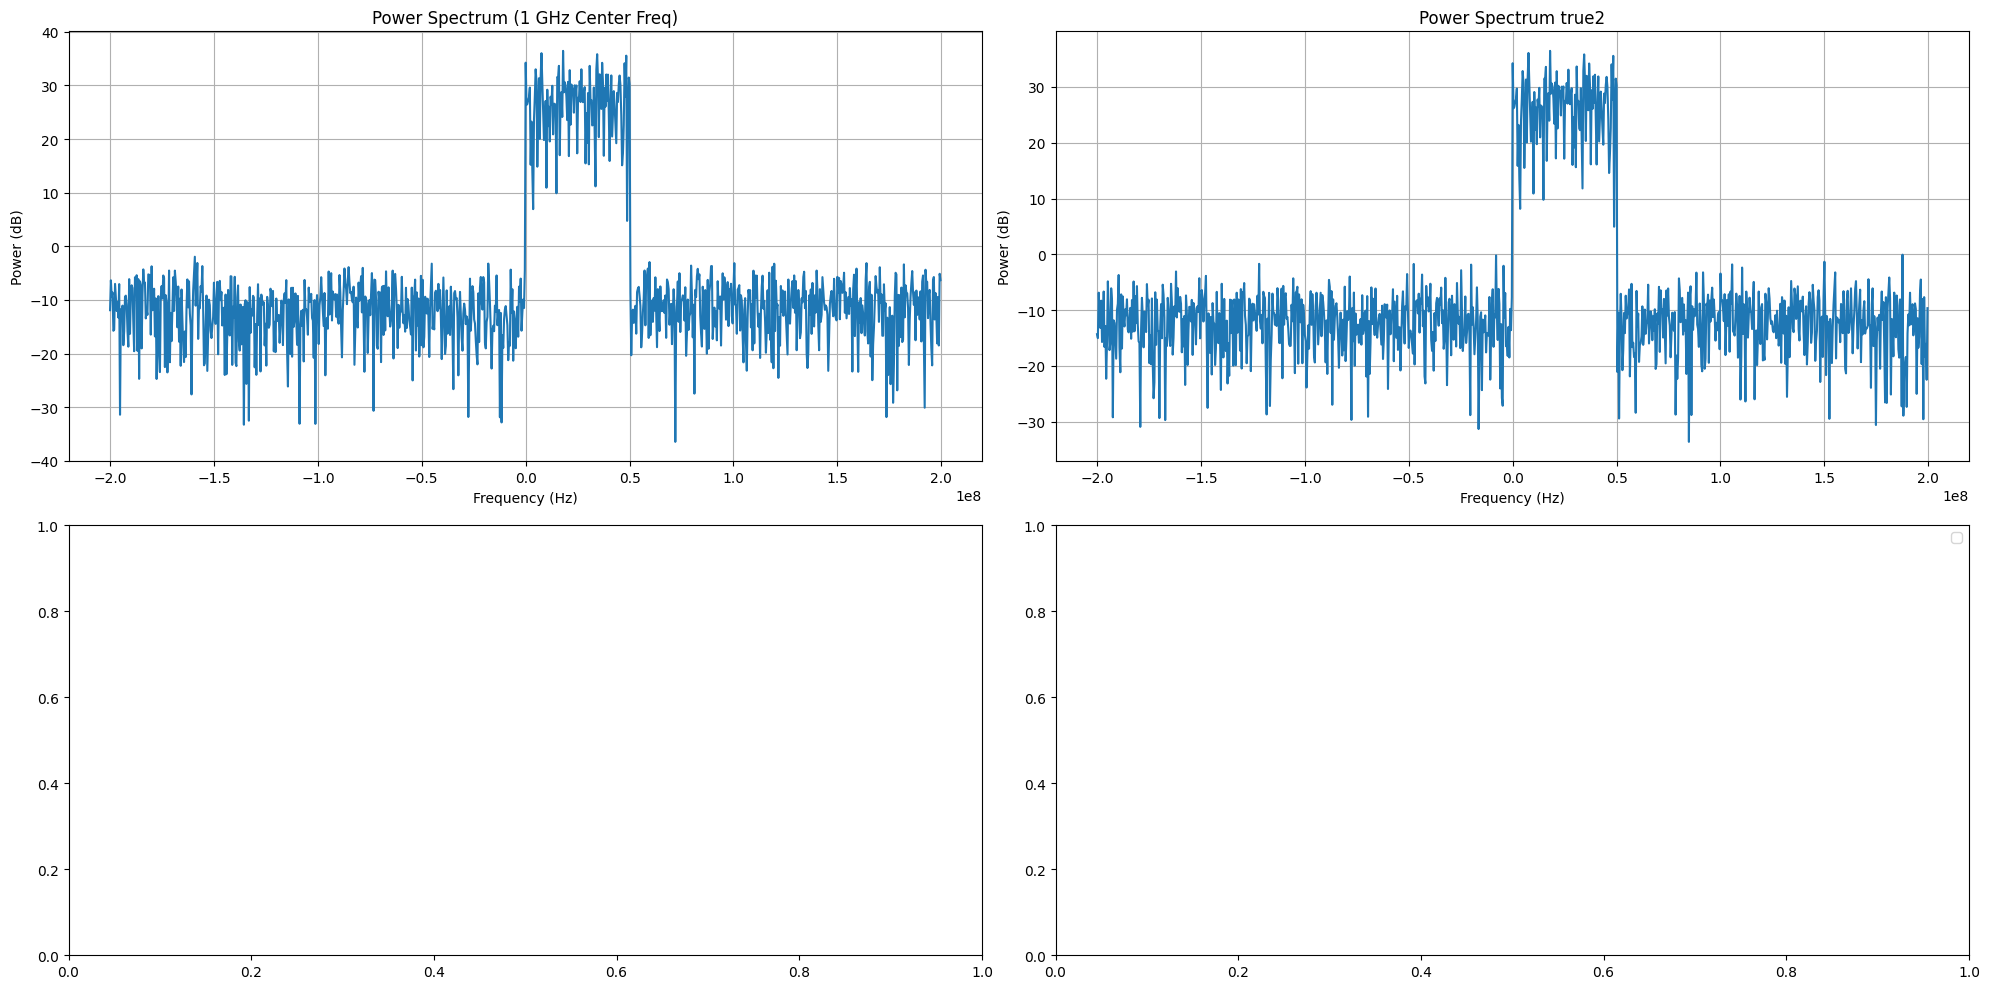

Sampling frequency: 400000000.0 Hz
Frequency resolution: 400000.000 Hz
Nyquist frequency: 200000000.0 Hz
Beamformed signal shape: (1000,)
Signal power: 1.00e-01


In [130]:
def plot_spectrum(signals, labels, fs):
    fig, axes = plt.subplots(2, len(labels), figsize=(20, 10))

    for i, (signal, label) in enumerate(zip(signals, labels)):
        # FFT along time axis
        fft_vals = np.fft.fftshift(np.fft.fft(signal))
        fft_freq = np.fft.fftshift(np.fft.fftfreq(len(signal), d=1/fs))
        power_spectrum = np.abs(fft_vals) ** 2
        power_db = 10 * np.log10(power_spectrum + 1e-12)  # Adding small number to avoid log(0)
        
        axes[0,i].plot(fft_freq, power_db, label=label)
        axes[0,i].set_xlabel('Frequency (Hz)')
        axes[0,i].set_ylabel('Power (dB)')
        axes[0,i].set_title(f'Power Spectrum {label}')
        axes[0,i].grid(True) 
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    # Print some diagnostics
    print(f"Sampling frequency: {fs:.1f} Hz")
    print(f"Frequency resolution: {fs/len(signal):.3f} Hz")
    print(f"Nyquist frequency: {fs/2:.1f} Hz")
    print(f"Beamformed signal shape: {signal.shape}")
    print(f"Signal power: {np.mean(np.abs(signal)**2):.2e}")
    

plot_spectrum([X[0,:], X[1, :]], ['(1 GHz Center Freq)', 'true2'], fs)

Text(0, 0.5, 'Power')

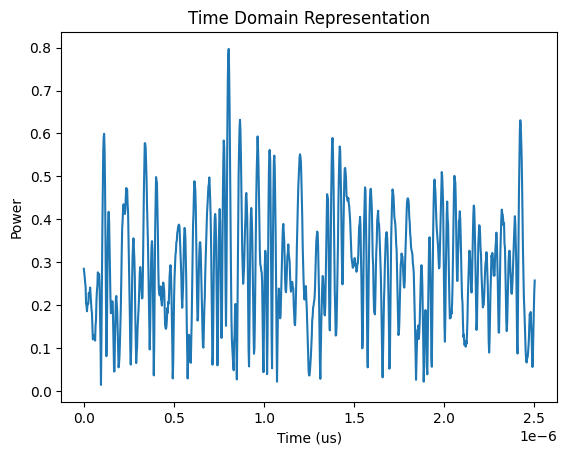

In [135]:
plt.plot(t, np.abs(X[1,:]))
plt.title("Time Domain Representation")
plt.xlabel("Time (us)")
plt.ylabel("Power")

In [152]:
array.positions
fs = 10e6
t = np.linspace(1, 1001 / fs , 1000)
freq_1 = 1.01 * 1e9
freq_2 = 1.015 * 1e9

power_1 = 1
power_2 = 10

signal_1 = np.exp(2j * np.pi * freq_1 * t)
signal_2 = np.exp(2j * np.pi * freq_2 * t)

current_power_1 = np.mean(np.abs(signal_1)**2)
current_power_2 = np.mean(np.abs(signal_2)**2)
signal_1 = signal_1 * np.sqrt(power_1 / current_power_1)
signal_2 = signal_2 * np.sqrt(power_2 / current_power_2)

steer_1 = array.steering_vector(np.deg2rad(20), np.array([constants.c / freq_1]))
steer_2 = array.steering_vector(np.deg2rad(45), np.array([constants.c / freq_2]))

X = steer_1 @ signal_1[np.newaxis] + steer_2 @ signal_2[np.newaxis]